In [1]:
import pandas as pb
import datetime
sber = pd.read_pickle('nis/sber.pickle').drop(['ticker', 'per'], axis = 1)
usru = pd.read_pickle('nis/usdrub.pickle').drop([498355, 498356])

NameError: name 'pd' is not defined

In [41]:
usru.head()

,date,time,open,high,low,close,vol
0,20170101,200100,61.5325,61.5325,61.5325,61.5325,1
1,20170101,210100,61.5200,61.5200,61.5200,61.5200,1
2,20170101,210600,61.6050,61.6050,61.6050,61.6050,1
3,20170101,211100,61.6050,61.6050,61.6050,61.6050,1
4,20170101,211600,61.6050,61.6050,61.6050,61.6050,1


In [42]:
sber.head()

,date,time,open,high,low,close,vol
0,20170103,100100,173.41,173.50,173.15,173.15,148360
1,20170103,100200,173.15,173.35,173.11,173.26,100970
2,20170103,100300,173.26,173.40,173.25,173.25,46330
3,20170103,100400,173.30,173.53,173.30,173.52,96690
4,20170103,100500,173.52,173.84,173.00,173.59,248160


In [ ]:
# reccoding date and time
date = list(sber['date'].values)
time = list(sber['time'].values)
tm = []
for i in range(0, len(date)):
    d = datetime.datetime(int(str(date[i])[:4]), int(str(date[i])[4:6]), int(str(date[i])[6:8]), int(str(time[i])[:2]), int(str(time[i])[2:4]))
    tm.append(d)
sber['timestamp'] = tm

date = list(usru['date'].values)
time = list(usru['time'].values)
tt = []
for t in time:
    t = str(t)
    if len(t) != 6:
        k = 6 - len(t)
        ti = k*'0'+t
        tt.append(ti)
    else:
        tt.append(t)
time = tt
tm = []
for i in range(0, len(date)):
    d = datetime.datetime(int(str(date[i])[:4]), int(str(date[i])[4:6]), int(str(date[i])[6:8]), int(str(time[i])[:2]), int(str(time[i])[2:4]))
    tm.append(d)
usru['timestamp'] = tm

In [2]:
usru = usru.drop(['date', 'time'], axis = 1)
sber = sber.drop(['date', 'time'], axis = 1)

NameError: name 'usru' is not defined

In [102]:
import matplotlib.pyplot as plt

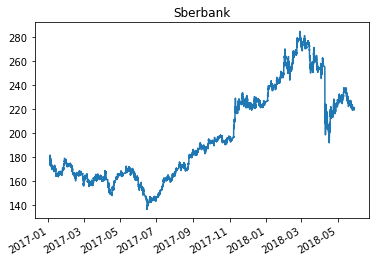

In [143]:
plt.plot(sber['timestamp'], sber['open'])
plt.gcf().autofmt_xdate()
plt.title('Sberbank')
plt.show()

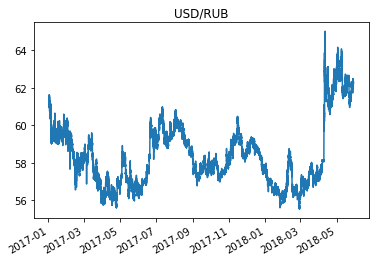

In [144]:
plt.plot(usru['timestamp'], usru['open'])
plt.gcf().autofmt_xdate()
plt.title('USD/RUB')
plt.show()

In [ ]:
# ohlc = ohlc[['open', 'high', 'low', 'close', 'vol', 'timestamp']]
# ohlc.columns = ['O', 'H', 'L', 'C', 'V', 'Date']
# ohlc = ohlc.set_index('Date')

In [1]:
import pandas as pd
import datetime
ohlc = pd.read_pickle('nis/ohlc_sber.pickle')

dict_keys(['o', 'h', 'l', 'c', 'v'])

In [122]:
test_ohlc = ohlc[ohlc.index > datetime.datetime(2018, 2, 28, 23, 59)]
ex_ohlc = ohlc[ohlc.index < datetime.datetime(2018, 3, 1, 0, 0)]

In [36]:
def test(i, ohlc):
    short_ma = i[0]
    long_ma = i[1]

    ms = ohlc.C.rolling(short_ma).mean()
    ml = ohlc.C.rolling(long_ma).mean()

    buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
    sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

    bt = pybacktest.Backtest(locals(), 'ma_cross')
    print(i, sum(bt.equity))
    return bt.equity

# for i in combs:
#     test(i = i, ohlc = ex_ohlc)

In [38]:
deals = test(i = [2000, 1590], ohlc = ohlc)


[2000, 1590] 171.39


## Backtesting

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

class backtest(object):
    # For this trading systems backtesting is needful to give as self.ohlc data
    # pandas.DataFrame with columns ['O', 'H', 'L', 'C'] (necesary to have upper letters)
    
    def __init__(self, data, coms = None):
        self.ohlc = data
#         self.signals = signals
#         self.mas = mas
        self.coms = {'moex':0.00425, 'binance':None, 'forex':None}
    
#     def test(self):
#         print(self.ohlc.head())
#         for i in range(0, round(len(self.ohlc['O'].values)**0.5)):
#             a = self.ohlc['C'].values[i] - self.ohlc['O'].values[i] 
#             print(a)
#         return a
        
    def backtest(self):
        seq = backtest.trade_sequence(self)
        seq = [s for s in seq if s[1] != 0]
        if len(seq) < 5:
            z = [0, 0]
            print('Need more than 5 values in trading sequence')
            pass
        else:

            self.dt = pd.DataFrame(seq, columns= ['Date', 'signal'])
            self.dt = self.dt.set_index('Date').merge(self.ohlc, left_index = True, right_index = True).drop('signal_y', axis = 1)
            self.t = self.dt[['signal_x', 'C']]
            t = self.t

            prices = []
            for i in t.iterrows():
                ts = i[1]
                price = i[1][1]

                if i[1][0] == 1:
                    price = price*(-1)

                elif i[1][0] == 2:
                    price = price

                else:
                    price = 0

                prices.append(price)


            z = [k for k in prices if k != 0]
            if z[0] > 0:
                z.remove(z[0])
                

            if z[-1] < 0:
                z.remove(z[-1])
                

            print('Total nominal profit = ', sum(z))    
        #print(prices)
        return z
    
    def trade_sequence(self):
        # get PURE WITHOUT REPEATS AND WORTH DELAS trading sequence of deals
        # write your signals in pd as 'signal' 
        n = list(self.ohlc['signal'].iteritems())
        first = self.ohlc[0:1].index[0]
        print(first)
        k = []
        for i in n:
            if i[0] == first:
                k.append([i[0], i[1]])
                prev = i[1]
            else:
                this = i[1]
                if this == prev:
                    pass
                else:
                    k.append([i[0], prev])
                prev = this
                
#         print('k = ', len(k))
        return k

        
    def mma(self, mas):
        # mma - function to cross Moving Averages trading system signals get   
        # short - long = buy and viceversa

        short = mas[0]
        long = mas[1]
            
#         print(long, short)
        
        a = np.where(self.ohlc.C.rolling(short).mean() - self.ohlc.C.rolling(long).mean() > 0, 1, 0)
        b = np.where(self.ohlc.C.rolling(long).mean() - self.ohlc.C.rolling(short).mean() > 0, 2, 0)
        ab = a + b
        # print(set(ab), len(ab))
        self.ohlc['signal'] = ab
#         self.signals = ab
#         print('buy = 1|', 'sell = 2|', 'wait = 0')

        return self.ohlc
    
#     def mma_select(self):
# #         step = round(self.ohlc.shape[0]/(self.ohlc.shape[0]**0.5))
#         max_ = self.ohlc.shape[0]//10
#         step = round(self.ohlc.shape[0]/(self.ohlc.shape[0]**0.33))
#         pace = round(step**0.2)
        
        
#         print('iter = ', len(range(0+step, max_, step))*len(range(0, step - pace, pace)))
#         for long in range(0+step, max_, step):
    
#             for short in range(0, long - pace, pace):
#                 self.dt_ = backtest.mma(self, mas = [long, short])
#                 sa = backtest.backtest(self, select = 'make')
            
#                 print([long, short], 'sum = {}'.format(sum(sa)))
# #                 mma(self, mas = [long, short])
                
        
        
        
        
        
        


In [422]:
# for forex
ohlc = pd.read_pickle('nis/usdrub.pickle')
ohlc.columns = ['O', 'H', 'L', 'C', 'V', 'Date']
ii = []
for i in ohlc['Date'].values: 
    ii.append(datetime.fromtimestamp(i.astype(datetime)/1000000000))
ohlc['date'] = ii
ohlc = ohlc.set_index('Date')
train = ohlc[ohlc.index < datetime(2018, 3, 1, 0, 0)]
test = ohlc[ohlc.index >= datetime(2018, 3, 1, 0, 0)]

ohlc.head()

,O,H,L,C,V,date
Date,,,,,,
2017-01-01 20:01:00,61.5325,61.5325,61.5325,61.5325,1,2017-01-01 23:01:00
2017-01-01 21:01:00,61.5200,61.5200,61.5200,61.5200,1,2017-01-02 00:01:00
2017-01-01 21:06:00,61.6050,61.6050,61.6050,61.6050,1,2017-01-02 00:06:00
2017-01-01 21:11:00,61.6050,61.6050,61.6050,61.6050,1,2017-01-02 00:11:00
2017-01-01 21:16:00,61.6050,61.6050,61.6050,61.6050,1,2017-01-02 00:16:00


In [221]:
# for stock
ohlc = pd.read_pickle('nis/ohlc_sber.pickle')
train = ohlc[ohlc.index < datetime(2018, 3, 1, 0, 0)]
test = ohlc[ohlc.index >= datetime(2018, 3, 1, 0, 0)]


In [423]:
max_ = train.shape[0]//10
step = round(train.shape[0]/(train.shape[0]**0.33))
pace = round(step**0.5)

profits = []
a = 1
print('iter = ', len(range(0+step, max_, step))*len(range(0, step - pace, pace)))
for long in range(0+step, max_, step):

    for short in range(0, long - pace, pace):
        print('step {}'.format(a))
        a += 1
        
        aa = backtest(data = train)
        aa.mma(mas = [long, short])
        okm = sum(aa.backtest())
        profits.append([okm, (long, short)])
        print('P = {}'.format(okm), [long, short])
        



iter =  532
step 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2017-01-01 20:01:00
Need more than 5 values in trading sequence
P = 0 [5785, 0]
step 2
2017-01-01 20:01:00
Total nominal profit =  -7.0803
P = -7.0802999999998875 [5785, 76]
step 3
2017-01-01 20:01:00
Total nominal profit =  -4.7475
P = -4.747499999999938 [5785, 152]
step 4
2017-01-01 20:01:00
Total nominal profit =  -2.801
P = -2.8009999999999735 [5785, 228]
step 5
2017-01-01 20:01:00
Total nominal profit =  -3.937
P = -3.937000000000019 [5785, 304]
step 6
2017-01-01 20:01:00
Total nominal profit =  -3.4037
P = -3.403699999999965 [5785, 380]
step 7
2017-01-01 20:01:00
Total nominal profit =  -1.8739
P = -1.8738999999999777 [5785, 456]
step 8
2017-01-01 20:01:00
Total nominal profit =  -1.8542
P = -1.8542000000000058 [5785, 532]
step 9
2017-01-01 20:01:00
Total nominal profit =  -1.0738
P = -1.0737999999999985 [5785, 608]
step 10
2017-01-01 20:01:00
Total nominal profit =  -1.1776
P = -1.1775999999999982 [5785, 684]
step 11
2017-01-01 20:01:00
Total nominal profit =  0.283
P = 0.283000

2017-01-01 20:01:00
Total nominal profit =  -2.8597
P = -2.859700000000025 [11570, 760]
step 88
2017-01-01 20:01:00
Total nominal profit =  -2.5405
P = -2.5404999999999944 [11570, 836]
step 89
2017-01-01 20:01:00
Total nominal profit =  -2.4451
P = -2.4451000000000036 [11570, 912]
step 90
2017-01-01 20:01:00
Total nominal profit =  -2.5782
P = -2.578200000000031 [11570, 988]
step 91
2017-01-01 20:01:00
Total nominal profit =  -2.7525
P = -2.7524999999999764 [11570, 1064]
step 92
2017-01-01 20:01:00
Total nominal profit =  -1.5544
P = -1.5544000000000153 [11570, 1140]
step 93
2017-01-01 20:01:00
Total nominal profit =  -0.3537
P = -0.35369999999999635 [11570, 1216]
step 94
2017-01-01 20:01:00
Total nominal profit =  -1.3949
P = -1.394900000000007 [11570, 1292]
step 95
2017-01-01 20:01:00
Total nominal profit =  -1.2574
P = -1.257400000000004 [11570, 1368]
step 96
2017-01-01 20:01:00
Total nominal profit =  -1.4478
P = -1.4477999999999938 [11570, 1444]
step 97
2017-01-01 20:01:00
Total n

2017-01-01 20:01:00
Total nominal profit =  -0.4434
P = -0.4433999999999827 [11570, 7144]
step 172
2017-01-01 20:01:00
Total nominal profit =  -0.8252
P = -0.8252000000000024 [11570, 7220]
step 173
2017-01-01 20:01:00
Total nominal profit =  -0.8437
P = -0.8437000000000054 [11570, 7296]
step 174
2017-01-01 20:01:00
Total nominal profit =  -1.1858
P = -1.185799999999979 [11570, 7372]
step 175
2017-01-01 20:01:00
Total nominal profit =  -1.5034
P = -1.5033999999999992 [11570, 7448]
step 176
2017-01-01 20:01:00
Total nominal profit =  -0.2638
P = -0.26379999999998915 [11570, 7524]
step 177
2017-01-01 20:01:00
Total nominal profit =  -0.5345
P = -0.5345000000000013 [11570, 7600]
step 178
2017-01-01 20:01:00
Total nominal profit =  -1.2432
P = -1.2431999999999874 [11570, 7676]
step 179
2017-01-01 20:01:00
Total nominal profit =  -1.532
P = -1.5319999999999965 [11570, 7752]
step 180
2017-01-01 20:01:00
Total nominal profit =  -0.729
P = -0.7290000000000063 [11570, 7828]
step 181
2017-01-01 2

2017-01-01 20:01:00
Total nominal profit =  -1.3812
P = -1.3811999999999856 [17355, 1976]
step 256
2017-01-01 20:01:00
Total nominal profit =  -1.0524
P = -1.0524000000000342 [17355, 2052]
step 257
2017-01-01 20:01:00
Total nominal profit =  -1.0664
P = -1.0663999999999945 [17355, 2128]
step 258
2017-01-01 20:01:00
Total nominal profit =  -2.136
P = -2.1359999999999957 [17355, 2204]
step 259
2017-01-01 20:01:00
Total nominal profit =  -1.6442
P = -1.6442000000000192 [17355, 2280]
step 260
2017-01-01 20:01:00
Total nominal profit =  -1.0839
P = -1.0838999999999928 [17355, 2356]
step 261
2017-01-01 20:01:00
Total nominal profit =  -1.6907
P = -1.6907000000000139 [17355, 2432]
step 262
2017-01-01 20:01:00
Total nominal profit =  -2.4386
P = -2.438600000000015 [17355, 2508]
step 263
2017-01-01 20:01:00
Total nominal profit =  -1.4232
P = -1.4232000000000014 [17355, 2584]
step 264
2017-01-01 20:01:00
Total nominal profit =  -1.9702
P = -1.9701999999999984 [17355, 2660]
step 265
2017-01-01 2

2017-01-01 20:01:00
Total nominal profit =  -4.623
P = -4.6229999999999976 [17355, 8360]
step 340
2017-01-01 20:01:00
Total nominal profit =  -4.5785
P = -4.578499999999984 [17355, 8436]
step 341
2017-01-01 20:01:00
Total nominal profit =  -4.2871
P = -4.287099999999988 [17355, 8512]
step 342
2017-01-01 20:01:00
Total nominal profit =  -3.873
P = -3.8730000000000047 [17355, 8588]
step 343
2017-01-01 20:01:00
Total nominal profit =  -3.8787
P = -3.8786999999999807 [17355, 8664]
step 344
2017-01-01 20:01:00
Total nominal profit =  -3.3314
P = -3.331399999999988 [17355, 8740]
step 345
2017-01-01 20:01:00
Total nominal profit =  -3.4548
P = -3.4547999999999845 [17355, 8816]
step 346
2017-01-01 20:01:00
Total nominal profit =  -3.4206
P = -3.4206000000000003 [17355, 8892]
step 347
2017-01-01 20:01:00
Total nominal profit =  -3.4261
P = -3.426099999999991 [17355, 8968]
step 348
2017-01-01 20:01:00
Total nominal profit =  -3.2889
P = -3.288899999999998 [17355, 9044]
step 349
2017-01-01 20:01:

2017-01-01 20:01:00
Total nominal profit =  -1.8135
P = -1.8135000000000048 [17355, 14668]
step 423
2017-01-01 20:01:00
Total nominal profit =  -2.6061
P = -2.606099999999998 [17355, 14744]
step 424
2017-01-01 20:01:00
Total nominal profit =  -2.1919
P = -2.1918999999999826 [17355, 14820]
step 425
2017-01-01 20:01:00
Total nominal profit =  -3.312
P = -3.3119999999999976 [17355, 14896]
step 426
2017-01-01 20:01:00
Total nominal profit =  -3.4309
P = -3.430899999999987 [17355, 14972]
step 427
2017-01-01 20:01:00
Total nominal profit =  -4.4202
P = -4.420199999999994 [17355, 15048]
step 428
2017-01-01 20:01:00
Total nominal profit =  -3.9382
P = -3.938199999999995 [17355, 15124]
step 429
2017-01-01 20:01:00
Total nominal profit =  -2.9905
P = -2.9905000000000115 [17355, 15200]
step 430
2017-01-01 20:01:00
Total nominal profit =  -3.4621
P = -3.4620999999999924 [17355, 15276]
step 431
2017-01-01 20:01:00
Total nominal profit =  -3.4048
P = -3.40480000000003 [17355, 15352]
step 432
2017-01

2017-01-01 20:01:00
Total nominal profit =  -4.9696
P = -4.969600000000007 [23140, 3724]
step 507
2017-01-01 20:01:00
Total nominal profit =  -5.1461
P = -5.146099999999997 [23140, 3800]
step 508
2017-01-01 20:01:00
Total nominal profit =  -5.4039
P = -5.403899999999972 [23140, 3876]
step 509
2017-01-01 20:01:00
Total nominal profit =  -4.8353
P = -4.8352999999999895 [23140, 3952]
step 510
2017-01-01 20:01:00
Total nominal profit =  -4.6492
P = -4.6492 [23140, 4028]
step 511
2017-01-01 20:01:00
Total nominal profit =  -4.53
P = -4.529999999999987 [23140, 4104]
step 512
2017-01-01 20:01:00
Total nominal profit =  -4.151
P = -4.151000000000003 [23140, 4180]
step 513
2017-01-01 20:01:00
Total nominal profit =  -4.4674
P = -4.467400000000005 [23140, 4256]
step 514
2017-01-01 20:01:00
Total nominal profit =  -4.7997
P = -4.799700000000001 [23140, 4332]
step 515
2017-01-01 20:01:00
Total nominal profit =  -4.4166
P = -4.416599999999995 [23140, 4408]
step 516
2017-01-01 20:01:00
Total nominal

2017-01-01 20:01:00
Total nominal profit =  -1.248
P = -1.2479999999999976 [23140, 10108]
step 591
2017-01-01 20:01:00
Total nominal profit =  -1.6121
P = -1.6121000000000052 [23140, 10184]
step 592
2017-01-01 20:01:00
Total nominal profit =  -1.3939
P = -1.3939000000000021 [23140, 10260]
step 593
2017-01-01 20:01:00
Total nominal profit =  -1.6983
P = -1.6983000000000033 [23140, 10336]
step 594
2017-01-01 20:01:00
Total nominal profit =  -1.7073
P = -1.7073000000000036 [23140, 10412]
step 595
2017-01-01 20:01:00
Total nominal profit =  -1.7318
P = -1.7317999999999927 [23140, 10488]
step 596
2017-01-01 20:01:00
Total nominal profit =  -1.9753
P = -1.97529999999999 [23140, 10564]
step 597
2017-01-01 20:01:00
Total nominal profit =  -1.9132
P = -1.9132000000000104 [23140, 10640]
step 598
2017-01-01 20:01:00
Total nominal profit =  -1.6227
P = -1.622700000000009 [23140, 10716]
step 599
2017-01-01 20:01:00
Total nominal profit =  -1.3184
P = -1.318399999999997 [23140, 10792]
step 600
2017-

2017-01-01 20:01:00
Total nominal profit =  -4.0301
P = -4.03009999999999 [23140, 16416]
step 674
2017-01-01 20:01:00
Total nominal profit =  -4.4492
P = -4.449200000000005 [23140, 16492]
step 675
2017-01-01 20:01:00
Total nominal profit =  -4.5609
P = -4.560899999999997 [23140, 16568]
step 676
2017-01-01 20:01:00
Total nominal profit =  -5.0528
P = -5.052800000000005 [23140, 16644]
step 677
2017-01-01 20:01:00
Total nominal profit =  -4.8223
P = -4.822300000000006 [23140, 16720]
step 678
2017-01-01 20:01:00
Total nominal profit =  -4.4497
P = -4.449700000000014 [23140, 16796]
step 679
2017-01-01 20:01:00
Total nominal profit =  -4.6535
P = -4.653500000000008 [23140, 16872]
step 680
2017-01-01 20:01:00
Total nominal profit =  -4.7528
P = -4.752800000000008 [23140, 16948]
step 681
2017-01-01 20:01:00
Total nominal profit =  -5.0083
P = -5.0083000000000055 [23140, 17024]
step 682
2017-01-01 20:01:00
Total nominal profit =  -5.2452
P = -5.245199999999997 [23140, 17100]
step 683
2017-01-01

KeyboardInterrupt: 

In [427]:
dt = pd.DataFrame(profits, columns = ['p', 'l']).sort_values('p')
dt.tail(10)

,p,l
76,0.0000,"(11570, 0)"
456,0.0000,"(23140, 0)"
0,0.0000,"(5785, 0)"
151,0.0137,"(11570, 5700)"
70,0.1508,"(5785, 5320)"
12,0.1764,"(5785, 912)"
10,0.2830,"(5785, 760)"
150,0.3283,"(11570, 5624)"
75,0.3802,"(5785, 5700)"
11,0.4920,"(5785, 836)"


### test sample and results

In [428]:
pd.DataFrame(profits, columns = ['profit', 'Mov.Avs']).sort_values('profit').tail(20)

,profit,Mov.Avs
418,-0.2703,"(17355, 14440)"
175,-0.2638,"(11570, 7524)"
181,-0.1800,"(11570, 7980)"
149,-0.1658,"(11570, 5548)"
281,-0.1485,"(17355, 4028)"
283,-0.1482,"(17355, 4180)"
154,-0.1348,"(11570, 5928)"
143,-0.1272,"(11570, 5092)"
155,-0.0574,"(11570, 6004)"
228,0.0000,"(17355, 0)"


In [198]:
dt.tail(2).values[0]

array([99.35000000000002, (8919, 7480)], dtype=object)

In [429]:
dt = pd.DataFrame(profits, columns = ['p', 'l']).sort_values('p')
rr = []
for i in range(1, 21):
    prr = dt['l'].tail(i).values[0]
    l = tuple(prr)[0]
    s = tuple(prr)[1]


    aa = backtest(data = train)
    aa.mma(mas = [l, s])
    e = len(aa.backtest())
    j = sum(aa.backtest())
    
    aa = backtest(data = ohlc)
    aa.mma(mas = [l, s])
    r = sum(aa.backtest()[e:])
    
    rr.append([j, r, (l, s)])
    
pd.DataFrame(rr, columns = ['profit_train', 'profit_test', 'Mov.Avs'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2017-01-01 20:01:00
Total nominal profit =  0.492
2017-01-01 20:01:00
Total nominal profit =  0.492
2017-01-01 20:01:00
Total nominal profit =  3.217
2017-01-01 20:01:00
Total nominal profit =  0.3802
2017-01-01 20:01:00
Total nominal profit =  0.3802
2017-01-01 20:01:00
Total nominal profit =  5.1767
2017-01-01 20:01:00
Total nominal profit =  0.3283
2017-01-01 20:01:00
Total nominal profit =  0.3283
2017-01-01 20:01:00
Total nominal profit =  5.0847
2017-01-01 20:01:00
Total nominal profit =  0.283
2017-01-01 20:01:00
Total nominal profit =  0.283
2017-01-01 20:01:00
Total nominal profit =  3.0463
2017-01-01 20:01:00
Total nominal profit =  0.1764
2017-01-01 20:01:00
Total nominal profit =  0.1764
2017-01-01 20:01:00
Total nominal profit =  3.2798
2017-01-01 20:01:00
Total nominal profit =  0.1508
2017-01-01 20:01:00
Total nominal profit =  0.1508
2017-01-01 20:01:00
Total nominal profit =  6.4321
2017-01-01 20:01:00
Total nominal profit =  0.0137
2017-01-01 20:01:00
Total nominal pr

,profit_train,profit_test,Mov.Avs
0,0.4920,2.7250,"(5785, 836)"
1,0.3802,4.7965,"(5785, 5700)"
2,0.3283,4.7564,"(11570, 5624)"
3,0.2830,2.7633,"(5785, 760)"
4,0.1764,3.1034,"(5785, 912)"
5,0.1508,6.2813,"(5785, 5320)"
6,0.0137,4.8255,"(11570, 5700)"
7,0.0000,0.0000,"(5785, 0)"
8,0.0000,0.0000,"(23140, 0)"
9,0.0000,0.0000,"(11570, 0)"


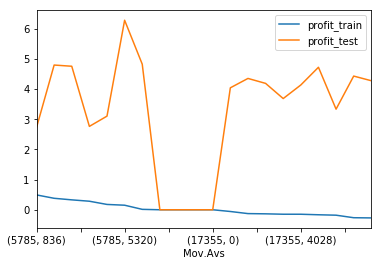

In [430]:
pd.DataFrame(rr, columns = ['profit_train', 'profit_test', 'Mov.Avs']).set_index('Mov.Avs').plot()
plt.show()

## Buy and Hold

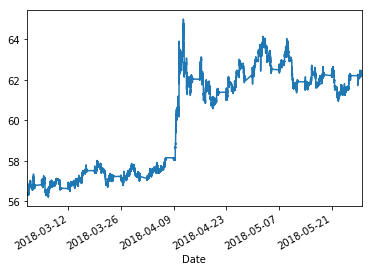

In [37]:
test['C'].plot()
plt.show()

In [39]:
f1 = test[0:1]['C'].values[0]
f2 = test[-1:]['C'].values[0]
print(f1, f2)
print((f2 - f1)/f1)
(f2 - f1)

56.3472 62.2838
0.105357497799


5.9365999999999985

## Random Forest for prediction move of price changes (up or down)

#### Feature creation

In [390]:
import numpy as np
ohlc = pd.read_pickle('nis/ohlc_sber.pickle')
ohlc['diff1'] = ohlc['C'] - ohlc['O']
ohlc['diff2'] = ohlc['H'] - ohlc['L']
ohlc = ohlc.pct_change()
ohlc['change'] = np.where(ohlc['C'] > 0, 1, 2)
# 1 - up, 2 - down or not change
ohlc['change'] = ohlc['change'].shift(-1)
ohlc = ohlc[['C', 'diff1', 'diff2', 'change']].dropna()
for l in range(1, 50):
    ohlc['C{}'.format(l)] = ohlc['C'].shift(l)
    ohlc['diff1_{}'.format(l)] = ohlc['diff1'].shift(l)
    ohlc['diff2_{}'.format(l)] = ohlc['diff2'].shift(l)
    ohlc['ch{}'.format(l)] = ohlc['change'].shift(l)




ohlc = ohlc.dropna()
print(ohlc.shape)
ohlc.head()

(181736, 200)


,C,diff1,diff2,change,C1,diff1_1,diff2_1,ch1,C2,diff1_2,...,diff2_47,ch47,C48,diff1_48,diff2_48,ch48,C49,diff1_49,diff2_49,ch49
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 10:51:00,0.000285,-2.333333,0.300000,2.0,-0.000285,-1.500000,-0.333333,1.0,0.000741,0.200000,...,0.533333,1.0,-0.000058,-1.090909,-0.375000,1.0,0.000635,-1.423077,-0.314286,2.0
2017-01-03 10:52:00,-0.000797,-2.500000,0.538462,1.0,0.000285,-2.333333,0.300000,2.0,-0.000285,-1.500000,...,2.652174,1.0,0.001558,-23.000000,0.533333,1.0,-0.000058,-1.090909,-0.375000,1.0
2017-01-03 10:53:00,0.001425,-2.583333,0.300000,2.0,-0.000797,-2.500000,0.538462,1.0,0.000285,-2.333333,...,0.500000,1.0,0.000403,-0.681818,2.652174,1.0,0.001558,-23.000000,0.533333,1.0
2017-01-03 10:54:00,-0.000398,-1.105263,-0.461538,1.0,0.001425,-2.583333,0.300000,2.0,-0.000797,-2.500000,...,-0.531746,2.0,0.003802,8.000000,0.500000,1.0,0.000403,-0.681818,2.652174,1.0
2017-01-03 10:55:00,0.000456,-5.000000,-0.357143,2.0,-0.000398,-1.105263,-0.461538,1.0,0.001425,-2.583333,...,-0.559322,2.0,0.001664,-0.476190,-0.531746,2.0,0.003802,8.000000,0.500000,1.0


In [36]:
# for forex
import pandas as pd
from datetime import datetime
ohlc = pd.read_pickle('nis/usdrub.pickle')
ohlc.columns = ['O', 'H', 'L', 'C', 'V', 'Date']
ii = []
for i in ohlc['Date'].values: 
    ii.append(datetime.fromtimestamp(i.astype(datetime)/1000000000))
ohlc['date'] = ii
ohlc = ohlc.set_index('Date').drop('date', axis = 1)
train = ohlc[ohlc.index < datetime(2018, 3, 1, 0, 0)]
test = ohlc[ohlc.index >= datetime(2018, 3, 1, 0, 0)]

In [3]:
import numpy as np


ohlc['diff1'] = ohlc['C'] - ohlc['O']
ohlc['diff2'] = ohlc['H'] - ohlc['L']
ohlc = ohlc.pct_change()
ohlc['change'] = np.where(ohlc['C'] > 0, 1, 2)
# 1 - up, 2 - down or not change
ohlc['change'] = ohlc['change'].shift(-1)
ohlc = ohlc[['C', 'diff1', 'diff2', 'change']].dropna()
for l in range(1, 50):
    ohlc['C{}'.format(l)] = ohlc['C'].shift(l)
    ohlc['diff1_{}'.format(l)] = ohlc['diff1'].shift(l)
    ohlc['diff2_{}'.format(l)] = ohlc['diff2'].shift(l)
    ohlc['ch{}'.format(l)] = ohlc['change'].shift(l)




# ohlc = ohlc.dropna()
print(ohlc.shape)
ohlc.head()

(464794, 200)


,C,diff1,diff2,change,C1,diff1_1,diff2_1,ch1,C2,diff1_2,...,diff2_47,ch47,C48,diff1_48,diff2_48,ch48,C49,diff1_49,diff2_49,ch49
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 22:06:00,-0.005211,-inf,inf,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 22:11:00,0.000000,0.000000,0.000000,2.0,-0.005211,-inf,inf,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 22:16:00,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,2.0,-0.005211,-inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 22:21:00,0.004974,-0.949533,-0.949533,2.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 22:26:00,-0.004855,-1.419753,-0.580247,2.0,0.004974,-0.949533,-0.949533,2.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ohlc['change'].describe()

count    464794.000000
mean          1.557626
std           0.496669
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: change, dtype: float64

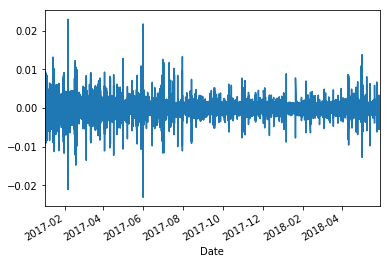

In [451]:
ohlc['C'].plot()
plt.show()

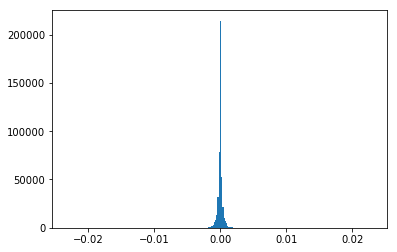

In [452]:
plt.hist(list(ohlc['C'].values)[1:], bins = 250)
plt.show()

In [5]:
ohlc = ohlc.replace([np.inf, -np.inf], 0)

train = ohlc[ohlc.index < datetime(2018, 3, 1, 0, 0)].dropna()
test = ohlc[ohlc.index >= datetime(2018, 3, 1, 0, 0)].dropna()

x_cols = [t for t in train.columns if t != 'change']

x_tr = train[x_cols]
y_tr = train['change'].astype(int)
x_te = test[x_cols]
y_te = test['change'].astype(int)

In [6]:
print(test.shape)
train.shape

(81432, 200)


(383313, 200)

In [7]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(20180301)
rf = RandomForestClassifier(n_estimators=100, max_depth=30, n_jobs=8, verbose=4)
# rf.set_params()
rf.fit(x_tr, y_tr)
print('train = ', rf.score(x_tr, y_tr))
print('test = ', rf.score(x_te, y_te))

building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100building tree 8 of 100







building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   28.5s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  3.0min


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.2s finished


train =  0.994860596953


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


test =  0.599825621377


In [19]:
predict = rf.predict(x_te)
len(predict)

[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


81432

In [23]:
test['signal'] = predict

In [24]:
# forex
ohlc = pd.read_pickle('nis/usdrub.pickle')
ohlc.columns = ['O', 'H', 'L', 'C', 'V', 'Date']
ii = []
for i in ohlc['Date'].values: 
    ii.append(datetime.fromtimestamp(i.astype(datetime)/1000000000))
ohlc['date'] = ii
ohlc = ohlc.set_index('Date').drop('date', axis = 1)

data = test[['signal', 'diff1_2']].merge(ohlc, left_index = True, right_index = True).drop('diff1_2', axis = 1)

In [16]:
#stock
data = test[['signal', 'diff1_2']].merge(pd.read_pickle('nis/ohlc_sber.pickle'), left_index = True, right_index = True).drop('diff1_2', axis = 1)

In [25]:
r = backtest(data = data)
r.trade_sequence()
k = r.backtest()[0]

2018-03-01 00:00:00
2018-03-01 00:00:00
Total nominal profit =  -85.1169


In [29]:
ee = r.backtest()[:-1]


2018-03-01 00:00:00
Total nominal profit =  -85.1169


[56.337200000000003,
 -56.341900000000003,
 56.336500000000001,
 -56.336500000000001,
 56.336500000000001,
 -56.338099999999997,
 56.344000000000001,
 -56.344000000000001,
 56.338999999999999,
 -56.338999999999999,
 56.371600000000001,
 -56.358800000000002,
 56.335000000000001,
 -56.332799999999999,
 56.332799999999999,
 -56.332799999999999,
 56.335500000000003,
 -56.347299999999997,
 56.353700000000003,
 -56.340800000000002,
 56.3371,
 -56.3476,
 56.341500000000003,
 -56.343000000000004,
 56.361499999999999,
 -56.363,
 56.364100000000001,
 -56.389000000000003,
 56.383899999999997,
 -56.394300000000001,
 56.400100000000002,
 -56.410600000000002,
 56.410299999999999,
 -56.410600000000002,
 56.410600000000002,
 -56.410299999999999,
 56.411499999999997,
 -56.412599999999998,
 56.411499999999997,
 -56.412599999999998,
 56.365200000000002,
 -56.397300000000001,
 56.383000000000003,
 -56.3979,
 56.386099999999999,
 -56.406399999999998,
 56.335099999999997,
 -56.373600000000003,
 56.304499999

In [34]:
sum(ee[1:])

-79.205299999999781